In [216]:
import pandas

df = pandas.read_csv('data/Titanic/titanic-train.csv', na_filter=True, 
                     converters = { 'Embarked': lambda s: s 
                                   if s != '' else 'Unknown' })
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [217]:
import sklearn.preprocessing

sex_codec = sklearn.preprocessing.LabelEncoder()
embarked_codec = sklearn.preprocessing.LabelBinarizer()
imputer = sklearn.preprocessing.Imputer();

In [218]:
embarked_codec.fit(df.Embarked)
embarked_columns = ['embarked_' + (s if s != '' else 'unknown')
                    for s in embarked_codec.classes_]

df_with_encodings = pandas.concat([
        df,
        pandas.DataFrame(sex_codec.fit_transform(df.Sex),
                         columns = ['SexEncoded']),
        pandas.DataFrame(embarked_codec.transform(df.Embarked),
                         columns=embarked_columns)
    ], axis=1)
df_with_encodings.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexEncoded,embarked_C,embarked_Q,embarked_S,embarked_Unknown
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0


# Select the features and define the targets

In [219]:
feature_names = ['Pclass',
                 'SexEncoded',
                 'Age',
                 'SibSp',
                 'Parch',
                 'Fare',
                 'embarked_Unknown',
                 'embarked_C', 
                 'embarked_Q', 
                 'embarked_S']

features = imputer.fit_transform(df_with_encodings[feature_names])
target = df['Survived']

# Modify Tuning Parameters Here

In [220]:
import sklearn.tree as tree

classifier = tree.DecisionTreeClassifier(max_depth=None,
                                         max_leaf_nodes=7,
                                         max_features=None,
                                         min_samples_leaf=25)
classifier.fit(features, target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=7, min_samples_leaf=25,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [221]:
importances = pandas.DataFrame(
    sorted(zip(classifier.feature_importances_, feature_names),
           reverse=True),
    columns = ['Importance', 'Feature'])
importances

,Importance,Feature
0,0.651349,SexEncoded
1,0.163133,Pclass
2,0.111669,Fare
3,0.059349,Age
4,0.014499,Parch
5,0.000000,embarked_Unknown
6,0.000000,embarked_S
7,0.000000,embarked_Q
8,0.000000,embarked_C
9,0.000000,SibSp


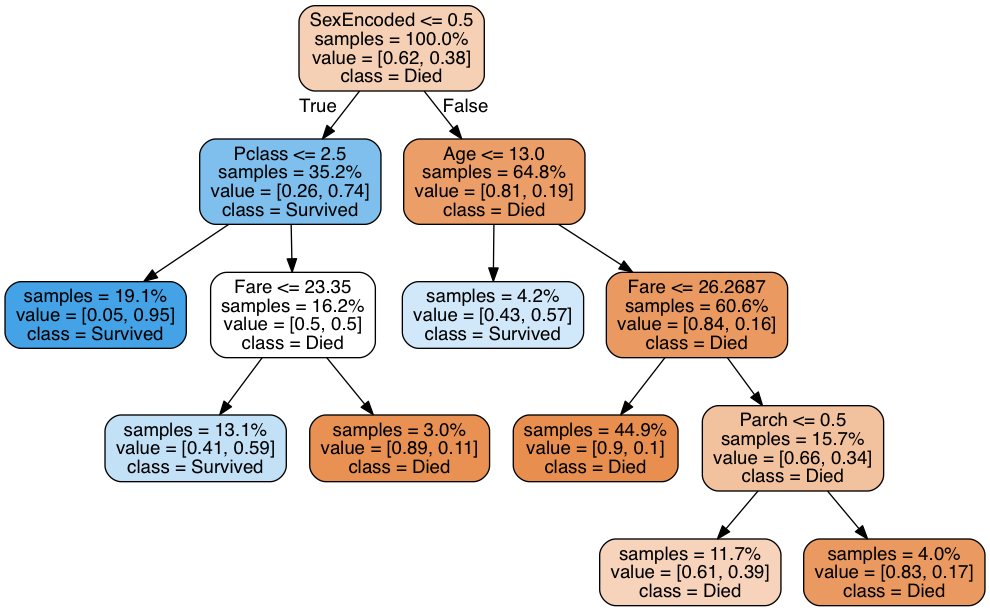

In [222]:
import pydotplus
from IPython.display import Image  
tree.export_graphviz(classifier, out_file='tree.dot',
                     class_names = ['Died', 'Survived'],
                     proportion=True, filled=True,
                     leaves_parallel=False, impurity=False,
                     rounded=True, feature_names=feature_names) 
Image(pydotplus.graph_from_dot_file('tree.dot').create_png())


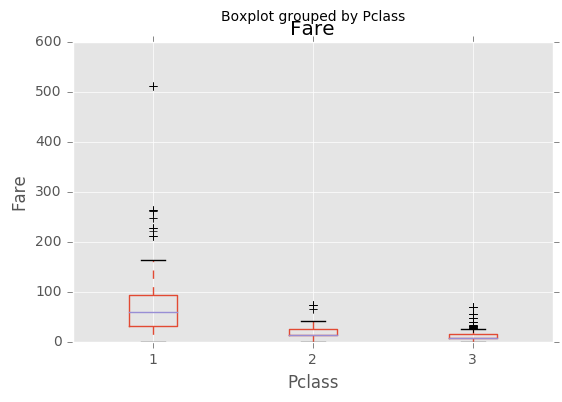

In [223]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df.boxplot(column='Fare', by='Pclass')
plt.ylabel('Fare');

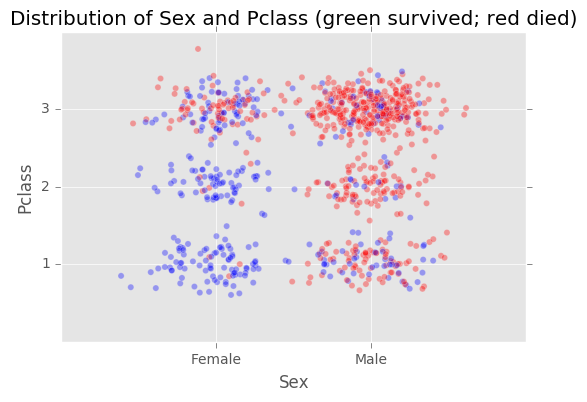

In [224]:
import numpy
def jittered(vector):
    return vector + numpy.random.normal(0.0, 0.20, len(vector))
plt.scatter(jittered(df_with_encodings.SexEncoded),
            jittered(df_with_encodings.Pclass),
            c=['blue' if s == 1 else 'red' for s 
               in df_with_encodings.Survived], alpha=0.35)
plt.xlabel('Sex')
plt.xticks([0.0, 1.0], ['Female', 'Male'])
plt.ylabel('Pclass')
plt.yticks([1, 2, 3], ['1', '2', '3']);
plt.title('Distribution of Sex and Pclass (green survived; red died)');

In [225]:
just_men = df_with_encodings[df.Sex == 'male']
just_women = df_with_encodings[df.Sex == 'female']

import sklearn.neighbors
import math

def density(df, survived=None, bw=6):
    if survived !=  None:
       df = df[df.Survived == survived]  

    ages = df.Age.dropna()
    dens = (sklearn.neighbors.kde.KernelDensity(kernel='gaussian',
                                               bandwidth=bw)
            .fit(ages.values.reshape((-1,1))))
    distinct_ages = sorted(set([age for age in ages]))
    return (distinct_ages, 
           [math.exp(x) for x in 
            dens.score_samples(numpy.matrix(distinct_ages)
                               .reshape((-1,1)))])

In [226]:
def make_plot(df, group_name):
    distinct_ages, age_density = density(df, 1, bw=5)
    plt.plot(distinct_ages, age_density, 'g-',
             linewidth=4, label='Survived')

    distinct_ages, age_density = density(df, 0, bw=5)
    plt.plot(distinct_ages, age_density, 'r-',
             linewidth=4, label='Died')

    distinct_ages, age_density = density(df, bw=5)
    plt.plot(distinct_ages, age_density, 'k-',
             linewidth=1, label='All')

    plt.xlabel('Age')
    plt.yticks([])
    plt.title('Age distribution of ' + 
              group_name + ' survivors (green) and casualties (red)')
    plt.legend();

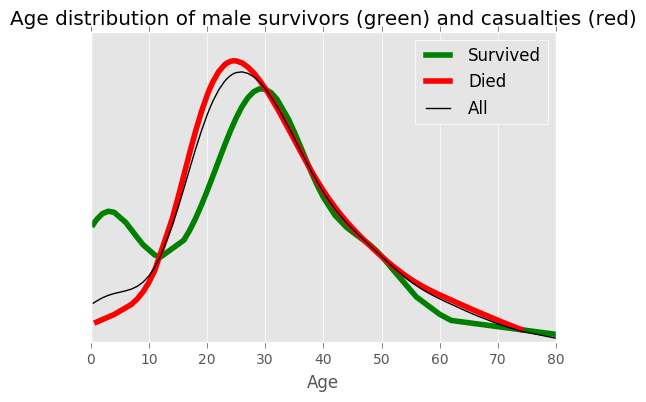

In [227]:
make_plot(just_men, 'male')

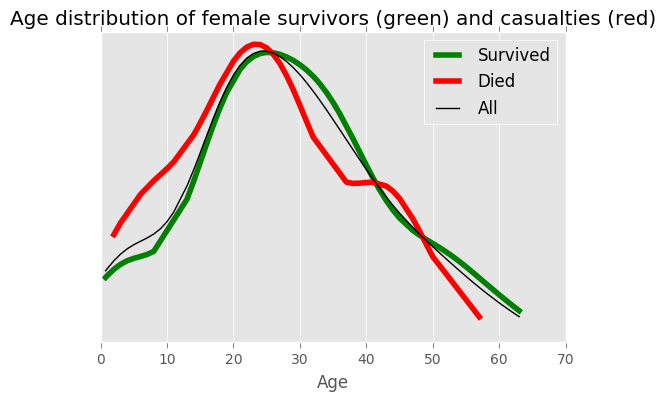

In [228]:
make_plot(just_women, 'female')